# Prediction of the number of migrations between two districts per year (GLS)

In [1]:
import math
import lxml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/pop_dyn/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def normalize_features(feature_vector, columns_to_scale):
    for feature in columns_to_scale:
        scaler = StandardScaler()
        feature_vector[feature] = scaler.fit_transform(feature_vector[feature])
    return feature_vector

def split_train_test_by_quartiles(feature_vector, feature_columns, target_column, n_splits_dist, labels, train_size):
    X = feature_vector.loc[:, (feature_columns)]
    y = feature_vector.loc[:, target_column]
    
    # extract quartiles from continuous target to equally split between train/test
    label_list = pd.qcut(feature_vector[target_column], n_splits_dist, labels=labels).tolist()
    
    # Split train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=32, 
                                                                  stratify=label_list)
    return X_train, X_test, y_train, y_test

In [4]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

In [5]:
f_vector.year.unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [6]:
f_vector.columns

Index(['migrations', 'destination', 'origin', 'year', 'n_inhabitants_or',
       'net_income_or', 'dist_size_or', 'rev_1000_inh_or', 'var_review_or',
       'unemployed_or', 'eldery_perc_or', 'd_inner_n_or', 'd_outer_n_or',
       'var_n_biz', 'var_sale_m2_or', 'var_rent_m2_or', 'n_tran_rs_or',
       'n_tran_new_rs_or', 'mortage_executions', 'n_inhabitants_de',
       'net_income_de', 'dist_size_de', 'rev_1000_inh_de', 'var_review_de',
       'unemployed_de', 'eldery_perc_de', 'd_inner_n_de', 'd_outer_n_de',
       'var_sale_m2_de', 'var_rent_m2_de', 'n_tran_rs_de', 'n_tran_new_rs_de',
       'net_income_diff', 'dist_size_diff', 'rev_1000_inh_diff',
       'var_review_diff', 'unemployed_diff', 'eldery_perc_diff',
       'd_inner_n_diff', 'd_outer_n_diff', 'var_sale_m2_diff',
       'var_rent_m2_diff', 'n_tran_rs_diff', 'n_tran_new_rs_diff'],
      dtype='object')

In [7]:
f_vector.loc[f_vector[f_vector['year'] <= 2008].index, 'period'] = 0
f_vector.loc[f_vector[(f_vector['year'] > 2008) & (f_vector['year'] <= 2011)].index, 'period'] = 2
f_vector.loc[f_vector[f_vector['year'] > 2011].index, 'period'] = 1

In [8]:
feature_columns = ['net_income_diff', 'dist_size_diff', 'rev_1000_inh_diff', 'unemployed_diff', 'eldery_perc_diff', 
                   'var_sale_m2_diff', 'var_rent_m2_diff', 'n_tran_new_rs_diff', 'n_tran_rs_diff', 'var_review_diff',
                   'n_tran_new_rs_diff', "mortage_executions", 'var_n_biz', "year", 'period' , "n_tran_rs_de", 
                   'net_income_de', 'rev_1000_inh_de', 'var_review_de', 'unemployed_de','eldery_perc_de', 
                   "var_sale_m2_de", "var_rent_m2_de", "n_tran_new_rs_de"]
target_column = "migrations"
n_splits_dist = 5
labels = ["q1","q2","q3","q4","q5"]
train_size = 0.9
alpha = 0.05

### Build train/test data sets

In [9]:
feature_vector = normalize_features(f_vector, feature_columns)
feature_vector['period'] = feature_vector['period'].astype(int)

In [15]:
feature_vector[feature_vector['period']==1].head()

,migrations,destination,origin,year,n_inhabitants_or,net_income_or,dist_size_or,rev_1000_inh_or,var_review_or,unemployed_or,...,var_review_diff,unemployed_diff,eldery_perc_diff,d_inner_n_diff,d_outer_n_diff,var_sale_m2_diff,var_rent_m2_diff,n_tran_rs_diff,n_tran_new_rs_diff,period
760,15.059167,Arganzuela,Centro,-0.870388,279832.0,30197.44,0.044689,0.0,0.0,3.320921,...,6.308324e-18,-0.301218,0.042877,-0.672684,-1.339798,-0.124762,0.568335,-0.228670,-0.228670,1
761,7.245340,Arganzuela,Retiro,-0.870388,239436.0,54250.43,0.038369,0.0,0.0,2.195576,...,6.308324e-18,0.562813,-0.959430,1.146374,0.873667,-0.707949,0.309058,-0.108397,-0.108397,1
762,3.342034,Arganzuela,Salamanca,-0.870388,286252.0,57371.99,0.046218,0.0,0.0,2.177801,...,6.308324e-18,0.576461,-1.186581,0.921141,0.526106,-0.323029,0.327413,-0.105144,-0.105144,1
763,2.312937,Arganzuela,Chamartín,-0.870388,281083.0,65216.04,0.044933,0.0,0.0,2.129264,...,6.308324e-18,0.613727,-0.837793,0.963837,0.701020,-0.334113,-0.103930,0.083133,0.083133,1
764,3.461791,Arganzuela,Tetuán,-0.870388,302622.0,32624.35,0.048325,0.0,0.0,3.109159,...,6.308324e-18,-0.138629,-0.615067,-0.982568,-1.047389,0.117963,-0.039715,-0.234458,-0.234458,1


In [10]:
f_vector.period.unique()

array([-1,  1,  0])

In [16]:
# Scale features
feature_vector = normalize_features(f_vector, feature_columns)
feature_vector['period'] = feature_vector['period'].astype(int)
feature_vector.loc[feature_vector[feature_vector['period']==1].index, 'period'] = 2
feature_vector.loc[feature_vector[feature_vector['period']==0].index, 'period'] = 1
feature_vector.loc[feature_vector[feature_vector['period']==-1].index, 'period'] = 0

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info = feature_vector.loc[:,(info_cols)]

X_train, X_test, y_train, y_test = split_train_test_by_quartiles(feature_vector, feature_columns, 
                                                                 target_column, n_splits_dist, labels, train_size)

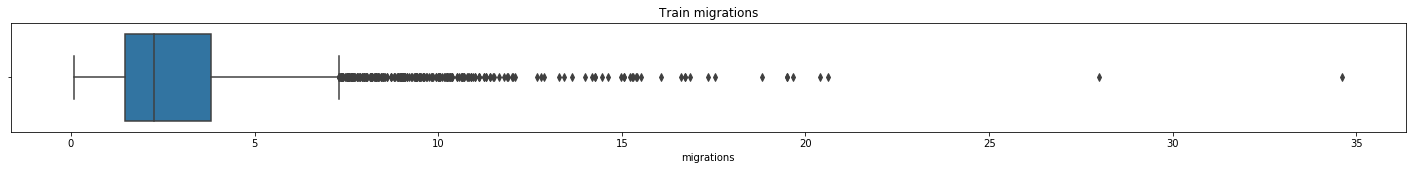

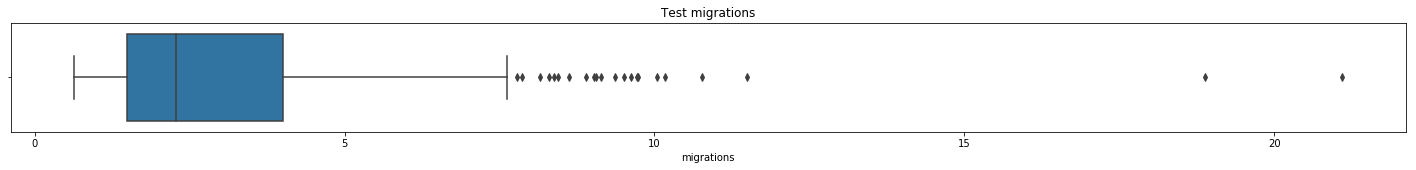

In [17]:
# Check if both samples have a similar distribution
_=plt.figure(figsize=(25, 2))
_=plt.title("Train migrations")
_=sns.boxplot(y_train)
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(y_test)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [18]:
# Add baseline
X_train_ = sm.add_constant(X_train.as_matrix())
X_test_ = sm.add_constant(X_test.as_matrix())

# Train linear regression and predict migrations
mod = sm.OLS(exog =X_train_, endog=np.array(y_train.astype(float))).fit()
y_pred = mod.predict(np.array(X_test_).astype(float))
summary = mod.summary(xname=feature_columns)

In [19]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     14.63
Date:                Wed, 08 Aug 2018   Prob (F-statistic):           3.49e-50
Time:                        11:22:18   Log-Likelihood:                -7980.9
No. Observations:                3420   AIC:                         1.601e+04
Df Residuals:                    3398   BIC:                         1.614e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_diff        3.1134      0.148     21.017      0.000       2.823       3.404
dist_size_diff         0.3161      0.120      2.640      0.008       0.081       0.551
rev_1000_inh_diff      0.0432      0.052      0.838      0.402      -0.058       0.144
unemployed_diff       -0.3999      0.068     -5.850      0.000      -0.534      -0.266
eldery_perc_diff       0.0946      0.127      0.745      0.456      -0.154       0.343
var_sale_m2_diff      -0.3502      0.079     -4.447      0.000      -0.505      -0.196
var_rent_m2_diff      -0.0809      0.062     -1.311      0.190      -0.202       0.040
n_tran_new_rs_diff     0.1008      0.057      1.777      0.076      -0.010       0.212
n_tran_rs_diff         0.0004      0.021      0.019      0.985      -0.041       0.042
var_review_diff        0.0004      0.021      0.019      0.985      -0.041       0.042
n_tran_new_rs_diff    -0.1585      0.061     -2.584      0.010      -0.279      -0.038
mortage_executions     0.0004      0.021      0.019      0.985      -0.041       0.042
var_n_biz              0.1106      0.128      0.866      0.386      -0.140       0.361
year                   0.0203      0.147      0.138      0.891      -0.269       0.309
period                -0.3899      0.116     -3.375      0.001      -0.616      -0.163
n_tran_rs_de           0.0174      0.129      0.134      0.893      -0.236       0.271
net_income_de          0.2681      0.033      8.114      0.000       0.203       0.333
rev_1000_inh_de       -0.2752      0.113     -2.443      0.015      -0.496      -0.054
var_review_de          0.3186      0.070      4.536      0.000       0.181       0.456
unemployed_de          0.1878      0.064      2.942      0.003       0.063       0.313
eldery_perc_de         0.0305      0.158      0.193      0.847      -0.279       0.340
var_sale_m2_de         0.2097      0.074      2.823      0.005       0.064       0.355
var_rent_m2_de         0.0606      0.077      0.783      0.434      -0.091       0.213
n_tran_new_rs_de      -0.1083      0.089     -1.223      0.222      -0.282       0.065
==============================================================================
Omnibus:                     2025.538   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24109.152
Skew:                           2.625   Prob(JB):                         0.00
Kurtosis:                      14.901   Cond. No.                     3.07e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
pd.read_html(summary.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls.csv",
                                              index=True, encoding='utf-8')

In [21]:
summary = pd.read_csv("../feature_extraction/data/results_gls.csv").rename(columns={'Unnamed: 0':'features'})
summary = summary.sort_values(by="P>|t|", ascending=False)
summary = summary.rename(columns={'P>|t|':'P-value'})

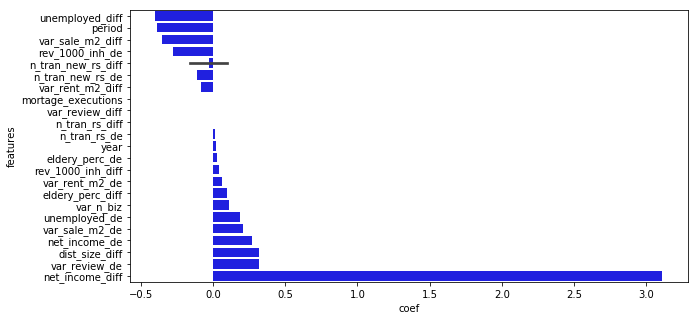

In [22]:
significant_factors = summary.copy()
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(10, 5))
sns.barplot(y="features",x="coef",data=significant_factors, color="blue")

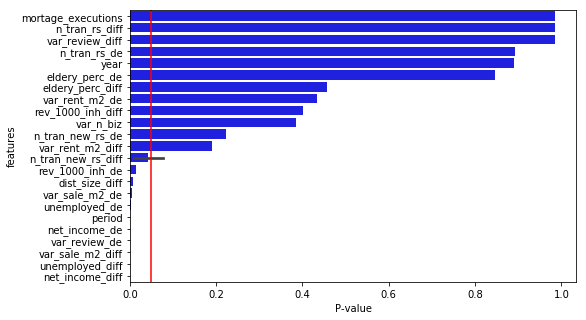

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary, color="blue")
plt.axvline(x=alpha, color="red")

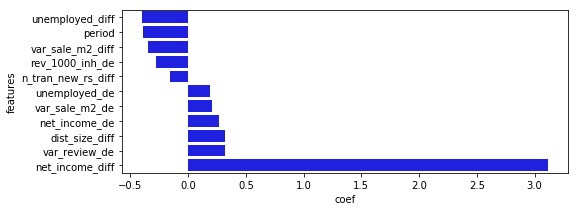

In [24]:
significant_factors = summary[summary["P-value"] < alpha]
significant_factors = significant_factors.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors, color="blue")

We only will consider factors that are within a confidence intervale of 95%.

Thus, when considering the whole period (2007-2016) these are the factors that have an impact on citizens migrations:
1. Positively correlated:
    - A higher level of unemployment rate in the destination district
    - A strong increase in the price per m2 with respect to the previous year of the destination district
    - A higher net income level in the destination district
    - A big difference on the size of the districts being the destination district bigger
    - A strong increase on the number of AirBnB reviews with respect to the previous year of the destination district
    - A big difference between destination and origin average net income being the destination higher
2. Negatively correlated:
    - A big difference on the number of real state transactions of new houses per 1000 inhabitants being the number of transactions in the destination district larger
    - A strong increase on the number of AirBnB reviews per 1000 inhabitants in the destination district
    - A strong increase on the price per m2 with respect to the previous year being this increase larger in the destination district
    - The period (0-before crisis, 1-after crisis, 2-during crisis)
    - A strong difference on the unemployment rates being the destination district rate highers
    
The features are incoherent, it is obvious that there are some that had high impact on triggering internal migrations but at different time frames. Thus, we will analyze the linear correlation with these factors per period (pre, during and after crisis).

### Evaluate performance of the model

In [25]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 2.37
 The r2 score in the test data set is: 0.08


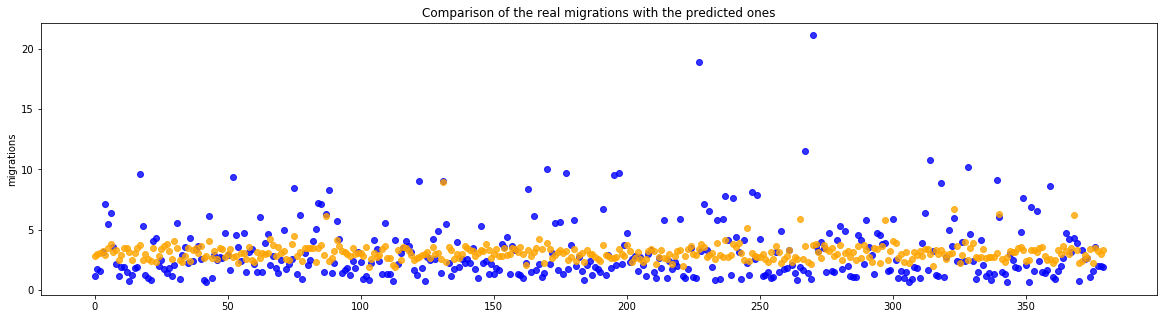

In [26]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

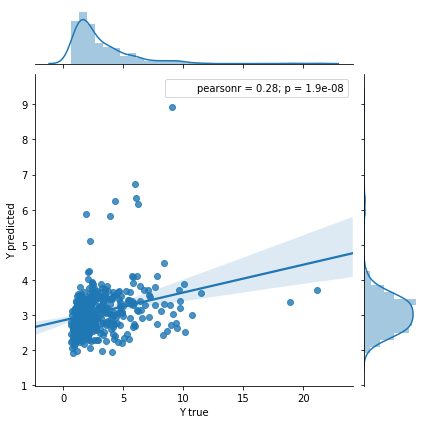

In [27]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Compare factors correlation with the internal migrations per period (pre, during, after crisis)

### Linear model until the economical crisis 2008

In [28]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_b = feature_vector[feature_vector['period']==0]
feature_columns_ = [x for x in feature_columns if x not in ['period','rev_1000_inh_diff','var_review_diff',
                                                            'rev_1000_inh_de','var_review_de']]

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_b = feature_vector_b.loc[:,(info_cols)]

X_train_b, X_test_b, y_train_b, y_test_b = split_train_test_by_quartiles(feature_vector_b, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [29]:
# Add baseline
X_train_b_ = sm.add_constant(X_train_b.as_matrix())
X_test_b_ = sm.add_constant(X_test_b.as_matrix())

# Train linear regression and predict migrations
mod_b = sm.OLS(exog =X_train_b_, endog=np.array(y_train_b.astype(float))).fit()
y_pred_b = mod_b.predict(np.array(X_test_b_).astype(float))
summary_b = mod_b.summary(xname=feature_columns_)

In [30]:
pd.read_html(summary_b.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_b_crisis.csv",
                                              index=True, encoding='utf-8')

In [31]:
summary_b = pd.read_csv("../feature_extraction/data/results_gls_b_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_b = summary_b.sort_values(by="P>|t|", ascending=False)
summary_b = summary_b.rename(columns={'P>|t|':'P-value'})

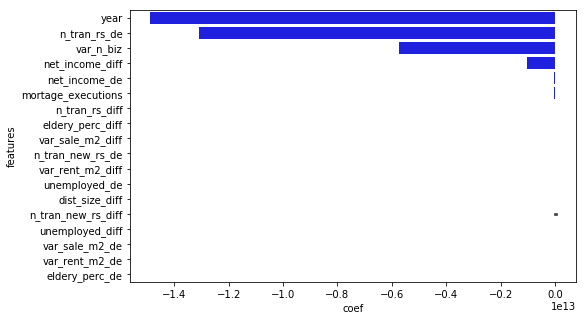

In [32]:
significant_factors_b = summary_b.copy()
significant_factors_b = significant_factors_b.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_b, color="blue")

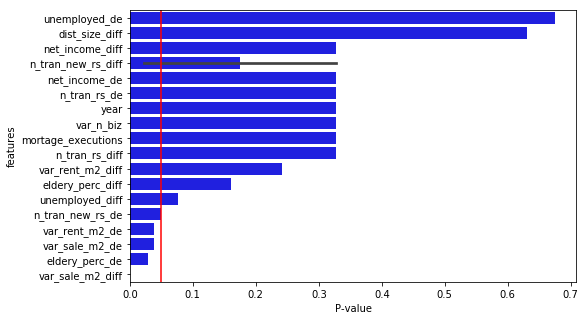

In [33]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_b, color="blue")
plt.axvline(x=alpha, color="red")

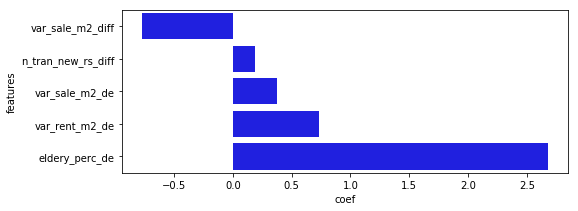

In [34]:
significant_factors_b = summary_b[summary_b["P-value"] < alpha]
significant_factors_b = significant_factors_b.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_b, color="blue")

We only will consider factors that are within a confidence intervale of 95%.

The model shows that during the first period before the crisis (2007-2008) migrations are correlated to:
1. Direct correlation:
    - The higher new flats transactions difference between destination and origin the higher the migration between those districts
    - The higher the increase of the price per m2 in the destination district in comparison to the previous year, the higher the migrations to that district
    - The higher the increase of the rent price per m2 in the destination district in comparison to the previous year, the higher the migrations to that district
    - The higher the percentage of eldery in the destination district, the higher the migrations to that district
2. Indirect correlation:
    - The higher the increase of the price per m2 with the previous year of the origin district in comparison to the destination the lower the number of migrations to the destination
    
We can clearly see that migrations are totally driven by the real state bubble, citizens move to districts looking for a great investment following the changes on prices driven by the real state speculation.

In [123]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_b, y_pred_b))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_b, y_pred_b)))

The RMSE in the test data set is: 4.34
 The r2 score in the test data set is: 0.13


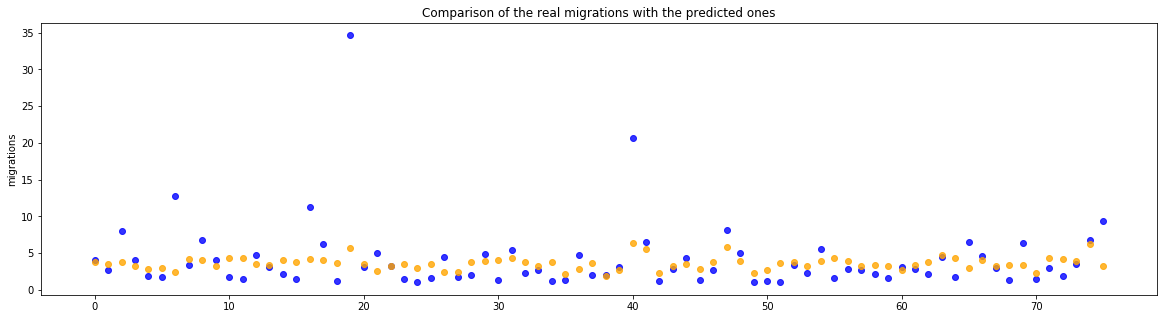

In [124]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_b)), y=y_test_b, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_b)), y=y_pred_b, fit_reg=False, color="orange")

### Linear model during the crisis 2009-2011

In [36]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_d = feature_vector[feature_vector['period']==2]
feature_columns_ = [x for x in feature_columns if x is not 'period']

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_d = feature_vector_d.loc[:,(info_cols)]

X_train_d, X_test_d, y_train_d, y_test_d = split_train_test_by_quartiles(feature_vector_d, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [37]:
# Add baseline
X_train_d_ = sm.add_constant(X_train_d.as_matrix())
X_test_d_ = sm.add_constant(X_test_d.as_matrix())

# Train linear regression and predict migrations
mod_d = sm.OLS(exog=X_train_d_, endog=np.array(y_train_d.astype(float))).fit()
y_pred_d = mod_d.predict(np.array(X_test_d_).astype(float))
summary_d = mod_d.summary(xname=feature_columns_)

In [38]:
summary_d

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     5.890
Date:                Wed, 08 Aug 2018   Prob (F-statistic):           2.83e-14
Time:                        11:25:55   Log-Likelihood:                -2408.7
No. Observations:                1026   AIC:                             4857.
Df Residuals:                    1006   BIC:                             4956.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_diff    -1.205e+13   1.27e+13     -0.946      0.345   -3.71e+13     1.3e+13
dist_size_diff         0.2800      0.280      1.002      0.317      -0.269       0.829
rev_1000_inh_diff      0.0925      0.096      0.962      0.336      -0.096       0.281
unemployed_diff      -83.3965     41.765     -1.997      0.046    -165.353      -1.439
eldery_perc_diff      -0.0552      0.345     -0.160      0.873      -0.732       0.621
var_sale_m2_diff      -0.4912      0.162     -3.025      0.003      -0.810      -0.173
var_rent_m2_diff      -0.2133      0.203     -1.050      0.294      -0.612       0.185
n_tran_new_rs_diff     0.1602      0.302      0.530      0.596      -0.433       0.753
n_tran_rs_diff      1.265e+11   1.34e+11      0.946      0.345   -1.36e+11    3.89e+11
var_review_diff     3.679e+10   3.89e+10      0.946      0.345   -3.96e+10    1.13e+11
n_tran_new_rs_diff    -0.0319      0.145     -0.220      0.826      -0.316       0.253
mortage_executions -1.633e+11   1.73e+11     -0.946      0.345   -5.02e+11    1.76e+11
var_n_biz          -1.467e+13   1.55e+13     -0.946      0.345   -4.51e+13    1.58e+13
year               -2.168e+13   2.29e+13     -0.946      0.345   -6.67e+13    2.33e+13
n_tran_rs_de       -1.169e+13   1.24e+13     -0.946      0.345   -3.59e+13    1.26e+13
net_income_de      -7.816e+10   8.26e+10     -0.946      0.345    -2.4e+11     8.4e+10
rev_1000_inh_de       -0.4027      0.281     -1.432      0.152      -0.954       0.149
var_review_de         83.4173     41.782      1.997      0.046       1.428     165.406
unemployed_de          0.0080      0.146      0.055      0.956      -0.279       0.295
eldery_perc_de         0.0070      0.460      0.015      0.988      -0.896       0.910
var_sale_m2_de         0.3411      0.155      2.203      0.028       0.037       0.645
var_rent_m2_de         0.2802      0.344      0.813      0.416      -0.396       0.956
n_tran_new_rs_de      -0.2873      0.554     -0.518      0.604      -1.375       0.801
==============================================================================
Omnibus:                      632.896   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6908.110
Skew:                           2.699   Prob(JB):                         0.00
Kurtosis:                      14.509   Cond. No.                     2.43e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.55e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [39]:
pd.read_html(summary_d.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_d_crisis.csv",
                                              index=True, encoding='utf-8')

In [40]:
summary_d = pd.read_csv("../feature_extraction/data/results_gls_d_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_d = summary_d.sort_values(by="P>|t|", ascending=False)
summary_d = summary_d.rename(columns={'P>|t|':'P-value'})

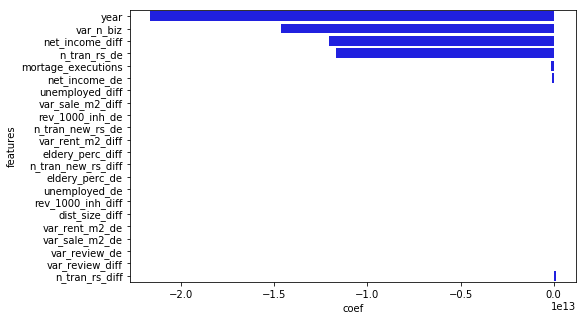

In [41]:
significant_factors_d = summary_d.copy()
significant_factors_d = significant_factors_d.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_d, color="blue")

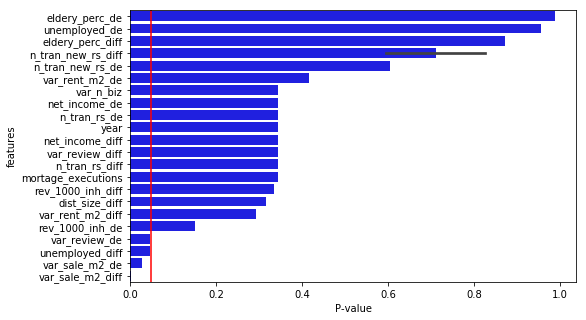

In [42]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_d, color="blue")
plt.axvline(x=alpha, color="red")

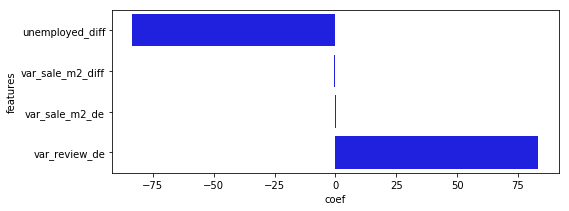

In [43]:
significant_factors_d = summary_d[summary_d["P-value"] < alpha]
significant_factors_d = significant_factors_d.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_d, color="blue")

We only will consider factors that are within a confidence intervale of 95%.

The model shows that during the international stock market crisis and the european crisis (2008-2011) migrations are correlated to:
1. Direct correlation:
    - The higher the increase of AirBnB reviews with respect to the previous year in the destination district, the higer the migrations to that district
2. Indirect correlation:
    - The lower the rate of unemployment in the destination district with respect to the rates in the origin district, the higher the migrations
    
In this period the factors that drive migrations change with respect of the previous period. Real state speculation factors are almost insignificant. The migrations seem to get more focused on moving to those districts where there is a lower unemployment rate and, a new phenomena, to those hype districts where tourists are focused or where the demand of AirBnB flats increased. This last factor is clearly the beginning of the gentrification of central areas and the end of the "brick" bubble. Real state is focused on business in second hand instead of new flats.

In [44]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_d, y_pred_d))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_d, y_pred_d)))

The RMSE in the test data set is: 3.03
 The r2 score in the test data set is: 0.08


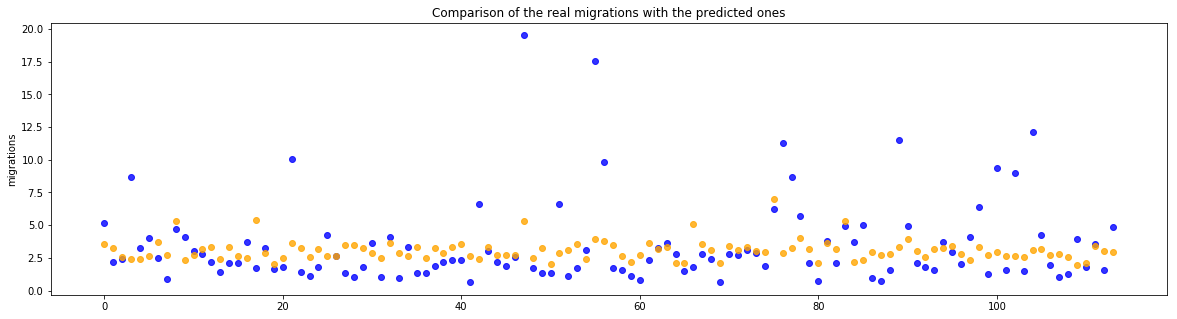

In [45]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_d)), y=y_test_d, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_d)), y=y_pred_d, fit_reg=False, color="orange")

### Linear model after the european crisis of 2011

In [46]:
# Scale features and ignore airbnb since it did not exists before 2010
feature_vector_a = feature_vector[feature_vector['period']==1]
feature_columns_ = [x for x in feature_columns if x is not 'period']

# Split data set: train/test X/Y
info_cols = ["origin","destination","year","migrations"]
info_a = feature_vector_a.loc[:,(info_cols)]

X_train_a, X_test_a, y_train_a, y_test_a = split_train_test_by_quartiles(feature_vector_a, feature_columns_, 
                                                                 target_column, n_splits_dist, labels, train_size)

In [47]:
# Add baseline
X_train_a_ = sm.add_constant(X_train_a.as_matrix())
X_test_a_ = sm.add_constant(X_test_a.as_matrix())

# Train linear regression and predict migrations
mod_a = sm.OLS(exog=X_train_a_, endog=np.array(y_train_a.astype(float))).fit()
y_pred_a = mod_a.predict(np.array(X_test_a_).astype(float))
summary_a = mod_a.summary(xname=feature_columns_)

In [48]:
summary_a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     5.573
Date:                Wed, 08 Aug 2018   Prob (F-statistic):           3.67e-14
Time:                        11:29:32   Log-Likelihood:                -3825.0
No. Observations:                1710   AIC:                             7692.
Df Residuals:                    1689   BIC:                             7806.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
net_income_diff        1.3388      0.791      1.693      0.091      -0.212       2.890
dist_size_diff         0.2565      0.191      1.344      0.179      -0.118       0.631
rev_1000_inh_diff      0.0555      0.068      0.813      0.416      -0.078       0.189
unemployed_diff       -0.2007      0.066     -3.048      0.002      -0.330      -0.072
eldery_perc_diff       0.0471      0.178      0.264      0.792      -0.302       0.397
var_sale_m2_diff      -0.3185      0.102     -3.108      0.002      -0.519      -0.118
var_rent_m2_diff      -0.1559      0.091     -1.708      0.088      -0.335       0.023
n_tran_new_rs_diff    -0.2547      0.124     -2.054      0.040      -0.498      -0.011
n_tran_rs_diff        -0.3607      0.091     -3.982      0.000      -0.538      -0.183
var_review_diff       -0.3607      0.091     -3.982      0.000      -0.538      -0.183
n_tran_new_rs_diff    -0.0799      0.101     -0.793      0.428      -0.277       0.118
mortage_executions    -0.3607      0.091     -3.982      0.000      -0.538      -0.183
var_n_biz              2.9115      0.803      3.628      0.000       1.337       4.486
year                   0.0417      0.162      0.257      0.797      -0.277       0.360
n_tran_rs_de           2.0971      1.030      2.036      0.042       0.077       4.118
net_income_de          0.7280      0.140      5.193      0.000       0.453       1.003
rev_1000_inh_de       -0.0942      0.190     -0.497      0.619      -0.466       0.278
var_review_de          0.1578      0.068      2.318      0.021       0.024       0.291
unemployed_de          0.1161      0.105      1.104      0.270      -0.090       0.322
eldery_perc_de         0.1876      0.232      0.807      0.419      -0.268       0.643
var_sale_m2_de         0.2055      0.095      2.160      0.031       0.019       0.392
var_rent_m2_de         0.2946      0.152      1.938      0.053      -0.003       0.593
n_tran_new_rs_de       0.4979      0.183      2.718      0.007       0.139       0.857
==============================================================================
Omnibus:                      788.844   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3922.110
Skew:                           2.190   Prob(JB):                         0.00
Kurtosis:                       8.988   Cond. No.                     5.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [49]:
pd.read_html(summary_a.tables[1].as_html(), header=0, 
             index_col='Unnamed: 0')[0].to_csv("../feature_extraction/data/results_gls_a_crisis.csv",
                                              index=True, encoding='utf-8')

In [50]:
summary_a = pd.read_csv("../feature_extraction/data/results_gls_a_crisis.csv").rename(columns={'Unnamed: 0':'features'})
summary_a = summary_a.sort_values(by="P>|t|", ascending=False)
summary_a = summary_a.rename(columns={'P>|t|':'P-value'})

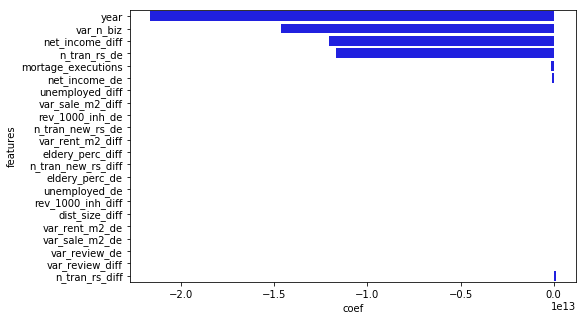

In [51]:
significant_factors_a = summary_d.copy()
significant_factors_a = significant_factors_a.sort_values(by="coef")
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="coef",data=significant_factors_a, color="blue")

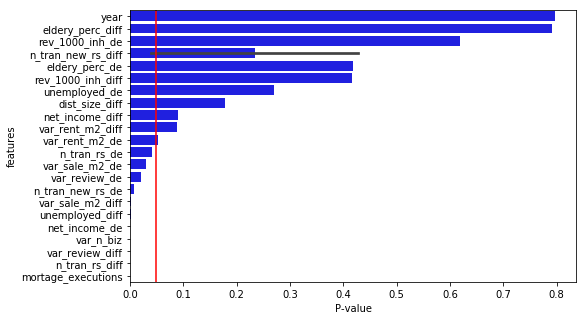

In [52]:
plt.figure(figsize=(8, 5))
sns.barplot(y="features",x="P-value",data=summary_a, color="blue")
plt.axvline(x=alpha, color="red")

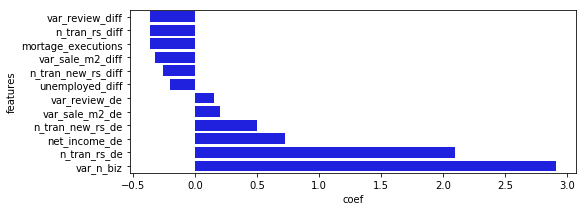

In [53]:
significant_factors_a = summary_a[summary_a["P-value"] < alpha]
significant_factors_a = significant_factors_a.sort_values(by="coef")
plt.figure(figsize=(8, 3))
sns.barplot(y="features",x="coef",data=significant_factors_a, color="blue")

We only will consider factors that are within a confidence intervale of 95%.

The model shows that after the european crisis (2011-2016) migrations are correlated to:
1. Direct correlation:
    - The higher the increase on AirBnB reviews with respect to the previous year in the destination district, the higher the amount of migrations
    - The higher the increase on the price per m2 with respect to the previous year in the destination district, the higher the amount of migrations
    - The higher the amount of new flat transactions in the destination district, the higher the migrations
    - The higher average the net income of the destination district, the higher the migrations
    - The higher the total transactions of flats in the destination district, the higher the migrations
    - The higher the number of business registered per year, the higher the amount of migrations
2. Indirect correlation:
    - The lower the unemployment level in the destination district in comparison to the rates in the origin, the higher the migrations
    - The lower the number of new flat transactions in the destination district in comparison to the origin, the higher the number of migrations
    - The lower the variation of price per m2 with respect of the previous year for the destination district in comparison to the origin (the most stable the prices are), the higher the number of migrations
    - The lower the mortage executions are per year, the higher the number of migrations (this factor represents more the two periods after the crisis than the number of mortage executions itself, it represents the temporal variation)
    - The lower the number of real state transactions in the destination district in comparison with the origin, the higher the amount of migrations
    - The lower the variation in the amount of reviews with respect to the previous year (well established gentrified districts) in the destination district with respect to the same variation in the origin district, the highest the migrations
    
When we compare the period before the crisis and this one, the factors that trigger migrations totally changed. The real estate is still driving them. However, the focus or the source of value changed. Now, there is not interest on massive new residencial contruction in the suburbs, there are too many and after the bursting of the "brick" bubble there flats are not longer quickly revalued. Now, the interest is on the acquisition of flats on districts of higher average income, where the prices per m2 are estable and its value is safe. Additionally, there is special interest on those districts that are established as gentrified, where the amount of AirBnB reviews do not increase that much over time anymore. Despite of the fact that the value of those flats does almost not grow, renting them through AirBnB or particulars could generate a consistent profit over time. Wellcome to the birth of the renting bubble.

Additionally, there are two temporal factors that more than having a value by itself, are an indicator of the two steps in this period. This factors are the mortage executions and the number of business registered. The first period after the crisis will still have a high rate of mortage executions and a not recovered number of business registered. The second part of this period, around 2014, the number of mortage executions dropped significantly and the amount of business registered started to grow.

In [54]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test_a, y_pred_a))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test_a, y_pred_a)))

The RMSE in the test data set is: 2.26
 The r2 score in the test data set is: -0.01


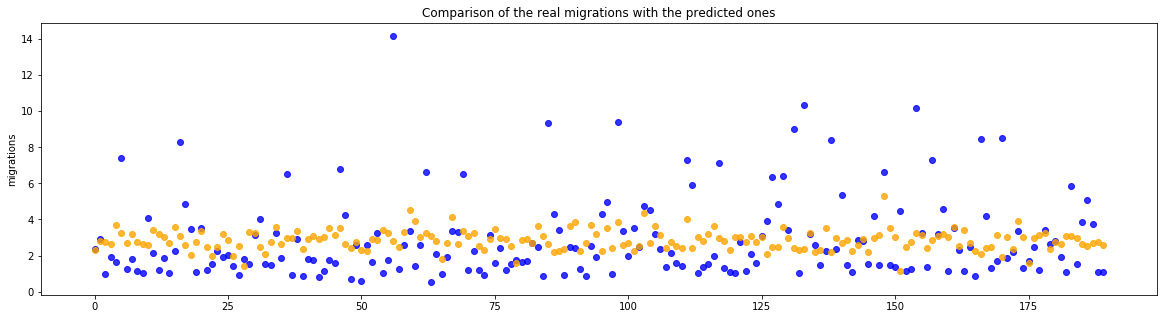

In [55]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test_a)), y=y_test_a, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred_a)), y=y_pred_a, fit_reg=False, color="orange")